# Stromableser Debug

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import urllib.request as ur
import os
from Stromableser import *

def show(imgs):
    size = 15
    num = len(imgs)
    fig, ax = plt.subplots(1, num, figsize=(size*num, size))
    for i in range(num):
        ax[i].axis('off')
        dia = ax[i].imshow(imgs[i], cmap='gray', interpolation='none')

In [2]:
print(getValue(readPatterns()))

-2


2021-10-24 22:50:45.587444 ERROR: incomplete digits {1}


In [3]:
patterns = readPatterns()

1228474


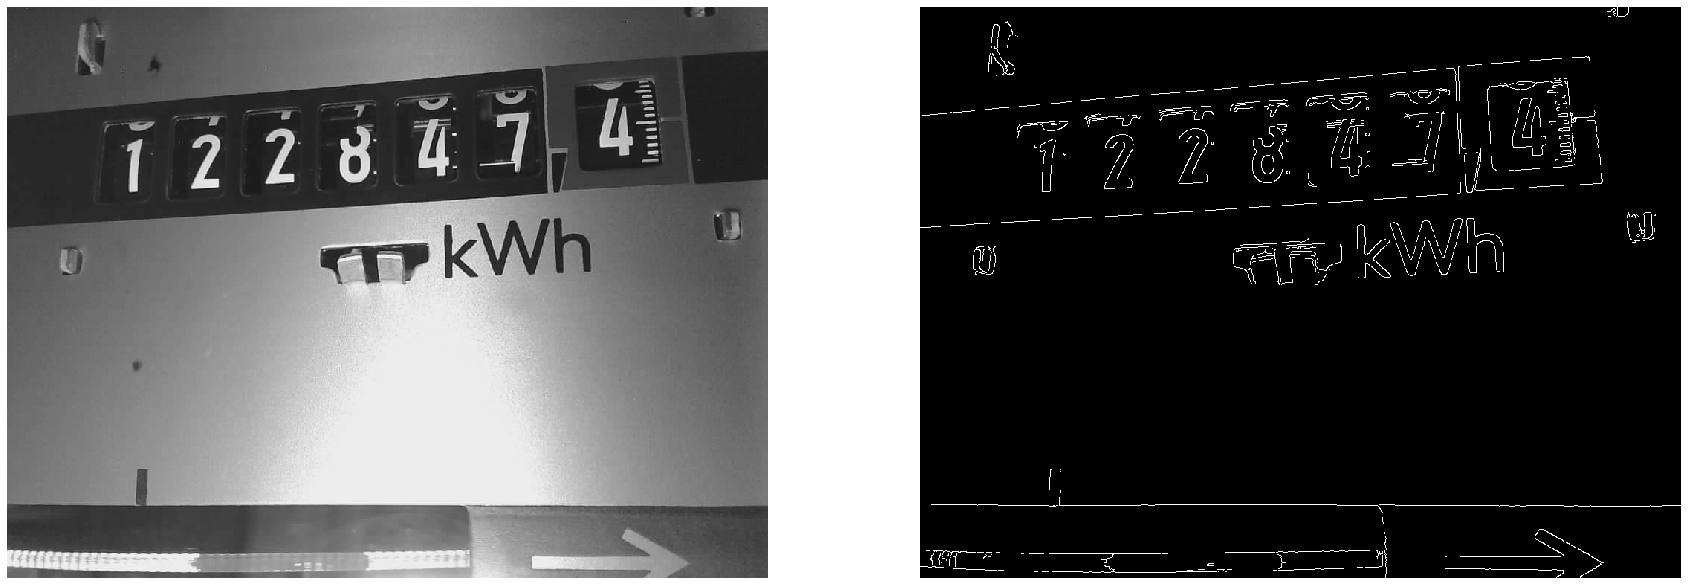

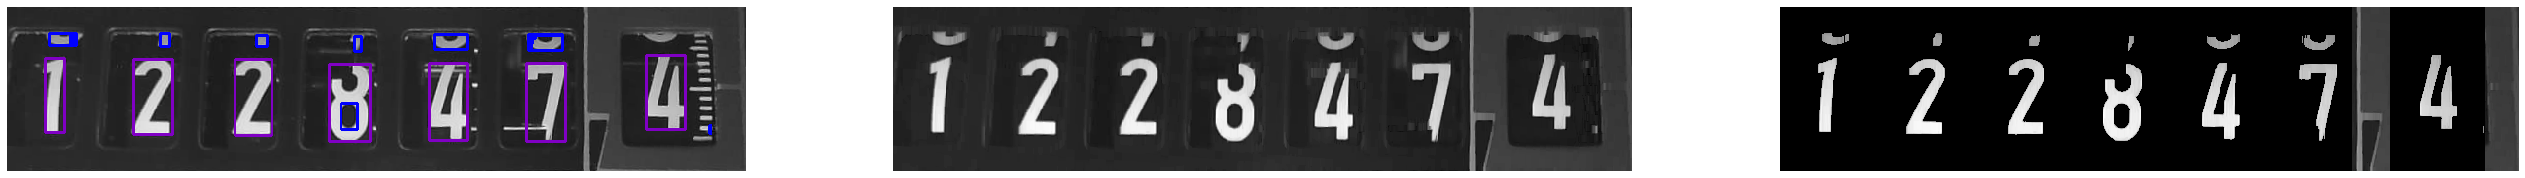

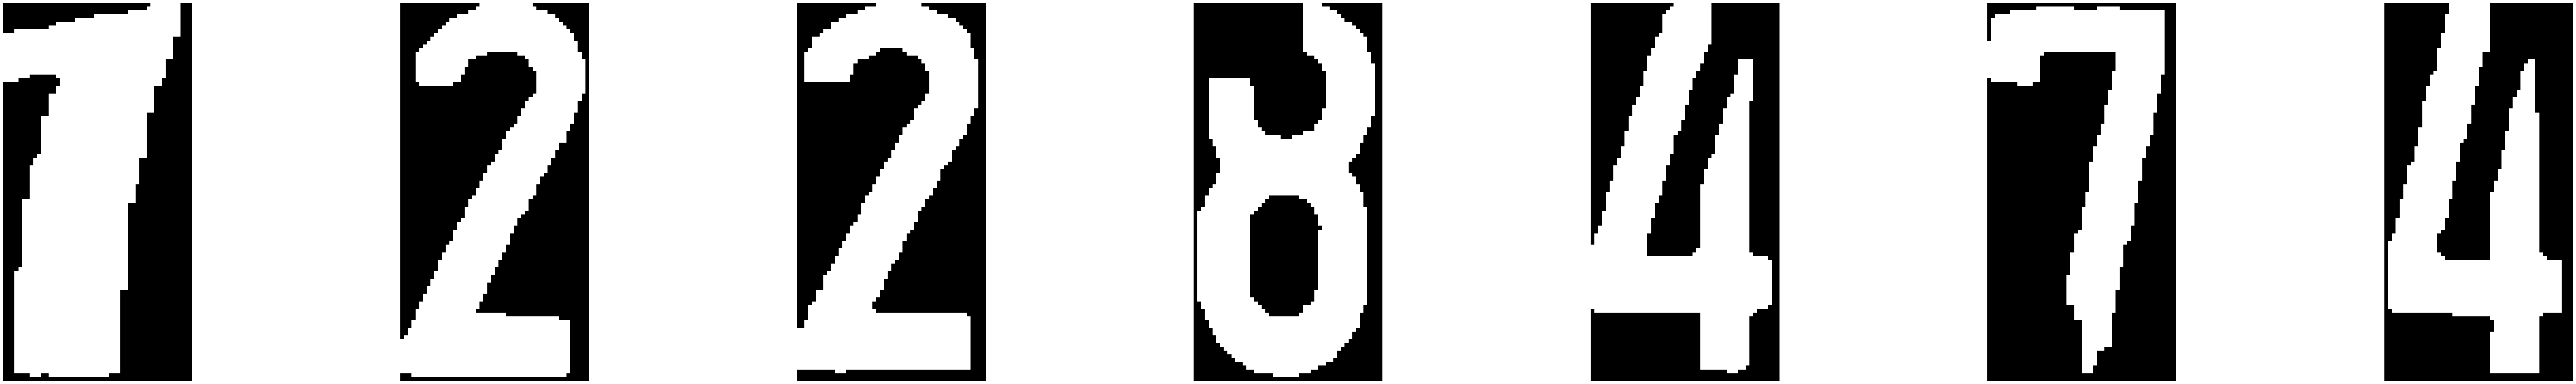

In [4]:
img = aquireGrayscaleImage("http://espcam1/snapshot.jpg")
#img = aquireGrayscaleImage(f"file://{os.path.abspath('image-test.jpg')}")
edges = applyEdgeFilter(img, area_blurr, area_low, area_ratio)
contour = findLargestSquare(edges)

show([img, edges])

if contour is not None:
    counter = undoPerspectiveDistortion(img, contour)
    boxes = cv2.cvtColor(counter, cv2.COLOR_GRAY2BGR)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,7))
    morphed = cv2.morphologyEx(counter, cv2.MORPH_OPEN, kernel) 
    counter = morphed.copy()
    digits, imgs = findDigits(counter, digit_blurr, digit_low, digit_ratio, patterns, boxes=boxes)
    show([boxes, morphed, counter])
    
    show([i for i in imgs.values()])

    num = numberFromDigits(digits)
    
    print(num)

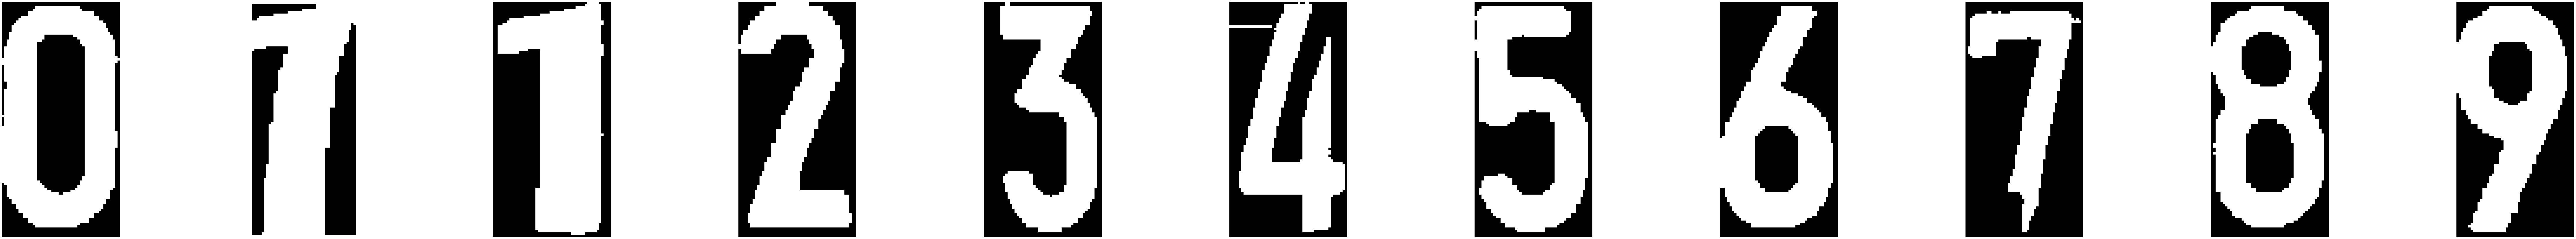

In [5]:
show([d for d in patterns.values()])

In [6]:
for d in sorted(imgs):
    digit, sim = getSimilarity(imgs[d], patterns)
    print(f"{d}. digit is '{digit}' with {sim:.2f} probability")

1. digit is '1' with 0.79 probability
2. digit is '2' with 0.85 probability
3. digit is '2' with 0.88 probability
4. digit is '8' with 0.84 probability
5. digit is '4' with 0.85 probability
6. digit is '7' with 0.88 probability
7. digit is '4' with 0.79 probability


In [7]:
def updatePattern(val, pos, ext=''):
    fname='digits'
    p = {}
    for pat in patterns:
        p[pat] = patterns[pat]
    p[f'd{val}{ext}'] = imgs[pos]
    np.savez_compressed(fname, d0=p['d0'], d1=p['d1'], d1b=p['d1b'], d2=p['d2'], d3=p['d3'], d4=p['d4'], d5=p['d5'], d6=p['d6'], d7=p['d7'], d8=p['d8'], d9=p['d9'])
    return readDigits(fname + '.npz')

In [8]:
# patterns = updatePattern(1, 6, 'b')

In [12]:

from influxdb import InfluxDBClient

# InfluxDB parameters
server = 'job4'
port = 8086
database='power'

# CLI interface
if __name__ == "__main__":
    # read table "measurements", fix anomalies and write into table "data"
    client = InfluxDBClient(host=server, port=port, database=database)
    response = client.query('select * from backup', epoch='s')
    print("Status: {}\n".format(response.error))
    points = response.get_points()
    data = []
    for point in points:
        if point['meter'] == None:
            point['meter'] = point['meter_1']
        # point['meter'] = point['meter'].strip('"')
        point.pop('meter_1', None)
        item = {
            "measurement": "energy",
            "tags": {
                "meter": "main"
            },
            "time": point["time"],
            "fields": {
                "watt": float(point["watt"])
            }
        }
        data.append(item)
        if len(data) == 10000:
            print("Add {} items".format(len(data)))
            client.write_points(data, time_precision='s')
            data = []
    print("Add {} items".format(len(data)))
    client.write_points(data, time_precision='s')


Status: None

Add 1384 items
